In [20]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum, row_number

from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter 환경에서 대화형 그래프 활성화
%matplotlib widget

# Scipy를 사용한 피어슨 상관계수와 p-value
# statistic: 피어슨 상관계수(상관관계의 강도와 방향을 나타냄)
# p-value가 0.05 미만이면 통계적으로 유의미하다고 함
# p-value는 낮을 수록 의미 있음
from scipy.stats import pearsonr


In [2]:
ss = SparkSession.builder\
.appName('YellowTaxi')\
.getOrCreate()

ss

24/12/12 17:46:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
trip_files = 'trips/*.csv'
zone_file = 'trips/code/lookup.csv'
directory = os.path.join(os.getcwd(), 'data')

In [4]:
df = ss.read.csv(f'file:///{directory}/{trip_files}', inferSchema = True, header = True)
df_zone = ss.read.csv(f'file:///{directory}/{zone_file}', inferSchema = True, header = True)
df, df_zone

(DataFrame[VendorID: int, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: int, trip_distance: double, RatecodeID: int, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double],
 DataFrame[LocationID: int, Borough: string, Zone: string, service_zone: string])

In [5]:
df.show(1)
df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2021-03-01 00:22:02|  2021-03-01 00:23:22|              1|          0.0|         1|                 N|         264|         264|           2|        3.0|  0.5|    0.5|       0.0|         0.0|                  0.3

In [12]:
df.count()

15000700

## 0. 방향
1. 쿼리 작성
2. 데이터 프레임으로 구현

## 1. 전처리

### 1-1. 임시 테이블 만들기

In [6]:
df.createOrReplaceTempView('table1')
df_zone.createOrReplaceTempView('table2')

### 1-2. 음수는 뭐지

In [160]:
ss.sql('''
    SELECT
        payment_type
        , min(tip_amount)
        , max(tip_amount)
        , min(total_amount)
        , max(total_amount)
    FROM table1 as A
    where tip_amount < 0
        or total_amount < 0

    GROUP BY payment_type
    
''').show()

+------------+---------------+---------------+-----------------+-----------------+
|payment_type|min(tip_amount)|max(tip_amount)|min(total_amount)|max(total_amount)|
+------------+---------------+---------------+-----------------+-----------------+
|        null|          -6.33|          15.13|           -95.88|            50.02|
|           1|         -83.95|            0.0|          -133.35|             -3.3|
|           3|         -111.1|          32.06|           -647.8|            -0.31|
|           4|        -333.32|          40.06|          -554.05|             -0.3|
|           2|            0.0|          31.26|           -634.8|            -0.35|
+------------+---------------+---------------+-----------------+-----------------+



### 1-3 결측치 처리

In [227]:
df.select(
    [
        sum(
            when(
                col(c).isNull() | isnan(c),1)\
        .otherwise(0)
            )\
        .alias(c) for c in df.columns
        
    ]    
).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|  834028|                   0|                    0|         834028|            0|    834028|            834028|           0|           0|      834028|          0|    0|      0|         0|           0|                    0

In [11]:
df.select('VendorID')\
    .where('VendorID IS NULL')\
    .show(10)

df.select('passenger_count')\
    .where('passenger_count IS NULL')\
    .show(10)

df.select('RatecodeID')\
    .where('RatecodeID IS NULL')\
    .show(10)

df.select('store_and_fwd_flag')\
    .where('store_and_fwd_flag IS NULL')\
    .show(10)

df.select('payment_type')\
    .where('payment_type IS NULL')\
    .show(10)

+--------+
|VendorID|
+--------+
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
+--------+
only showing top 10 rows



+---------------+
|passenger_count|
+---------------+
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
+---------------+
only showing top 10 rows



+----------+
|RatecodeID|
+----------+
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
+----------+
only showing top 10 rows



+------------------+
|store_and_fwd_flag|
+------------------+
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
+------------------+
only showing top 10 rows



+------------+
|payment_type|
+------------+
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
|        null|
+------------+
only showing top 10 rows



In [29]:
ws_VendorID = Window.orderBy('VendorID')

df.withColumn('VendorID'
              , row_number().over(ws_VendorID)        
              )\
.show(10)

24/12/12 18:46:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2021-06-01 11:39:00|  2021-06-01 11:56:00|           null|         8.76|      null|              null|          76|         210|        null|      27.72| 2.75|    0.5|       0.0|         0.0|                  0.3

In [16]:
df.select('VendorID')\
    .where('VendorID IS NULL')\
    .show(10)


DataFrame[VendorID: int, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: int, trip_distance: double, RatecodeID: int, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double]

## 2. 분석

### 2-1. 운행 거리(trip_distance)와 요금(total_amount)의 상관관계 분석

#### 2-1-1) 기초 통계 데이터 확인

In [106]:
ss.sql('''
    SELECT
        
        FLOOR(trip_distance/10) * 10 as range_distance
        -- , AVG(trip_distance)
        , ROUND(AVG(total_amount), 2) as avg_total_amount_by_range
        , MIN(total_amount) as min_total_amount_by_range
        , MAX(total_amount) as max_total_amount_by_range
    FROM table1
    
    GROUP BY range_distance    

    ORDER BY range_distance
''').show()

+--------------+-------------------------+-------------------------+-------------------------+
|range_distance|avg_total_amount_by_range|min_total_amount_by_range|max_total_amount_by_range|
+--------------+-------------------------+-------------------------+-------------------------+
|             0|                    16.28|                  -554.05|                 398469.2|
|            10|                    55.74|                   -282.8|                   1165.3|
|            20|                    73.88|                   -518.8|                   1320.8|
|            30|                   117.13|                   -634.8|                    634.8|
|            40|                   134.92|                   -647.8|                    647.8|
|            50|                   150.59|                  -327.05|                   456.84|
|            60|                   118.68|                  -314.55|                   481.45|
|            70|                   127.48|        

#### 2-1-2) Pandas 데이터프레임으로 만들기

In [107]:
df1 = ss.sql('''
    SELECT
        
        FLOOR(trip_distance/10) * 10 as range_distance
        -- , AVG(trip_distance) range_distance 컬럼과 사실상 동일한 값
        , ROUND(AVG(total_amount), 2) as avg_total_amount_by_range
        , MIN(total_amount) as min_total_amount_by_range
        , MAX(total_amount) as max_total_amount_by_range
    FROM table1
    
    GROUP BY range_distance    

    ORDER BY range_distance
''').toPandas()

#### 2-1-3) 상관계수 파악

In [111]:
df1.corr()

,range_distance,avg_total_amount_by_range,min_total_amount_by_range,max_total_amount_by_range
range_distance,1.000000,-0.113127,-0.014220,-0.043858
avg_total_amount_by_range,-0.113127,1.000000,0.829364,0.001031
min_total_amount_by_range,-0.014220,0.829364,1.000000,-0.160525
max_total_amount_by_range,-0.043858,0.001031,-0.160525,1.000000


In [105]:
statistic, pvalue = pearsonr(df1['range_distance'], df1['avg_total_amount_by_range'])
pvalue

0.0018896728517615062

#### 2-1-4) 시각화

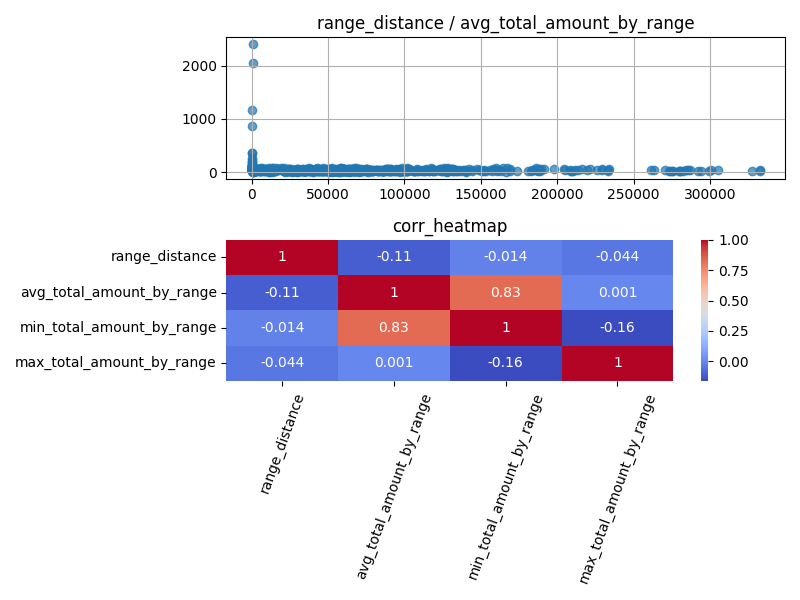

In [118]:
plt.figure(figsize = (8,6))

axes1 = plt.subplot(2,1,1)
axes1.scatter(df1['range_distance'], df1['avg_total_amount_by_range'], alpha = 0.7)
axes1.grid(True)
plt.title('range_distance / avg_total_amount_by_range')

axes2 = plt.subplot(2,1,2)
sns.heatmap(df1.corr(), annot =True, cmap = 'coolwarm')
plt.xticks(rotation = 70)
plt.title('corr_heatmap')

plt.tight_layout()
plt.show()

#### 2-1-5) 결론

<span style="
display : block;
background-color:#fff5b1;
color : red;
font-size : 20px;
font-weight : bold;
text-align : center;">[결론]</span>

- 이동 거리가 증가하면, 평균 운임이 음의 상관관계를 가져, 살짝 줄어드는 모습을 볼 수 있다
- 또한 이동 거리와 평균 운임의 p-value가 0.05 미만임에, 귀무가설(두 변수간 상관 관계가 없다)은 기각된다.
- 하지만 상관계수가 -0.11로 매우 약한 강도를 가지고 있다.
- 즉, 이동 거리와 평균 운임은 약한 음의 상관 관계를 가진다.- 

### 2-2. 피크 시간대 요금 분석

#### 2-2-1) 기초 통계 데이터 확인

In [120]:
ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
        , ROUND(AVG(total_amount), 2) as AVG_total_amount_by_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY time_hour

''').show()

+---------+--------+------------------------+
|time_hour|cnt_HOUR|AVG_total_amount_by_HOUR|
+---------+--------+------------------------+
|        0|  273553|                   21.43|
|        1|  160424|                   20.84|
|        2|   97218|                   20.36|
|        3|   57806|                   21.07|
|        4|   45410|                   25.54|
|        5|   82073|                   26.55|
|        6|  241020|                   21.33|
|        7|  438938|                   18.84|
|        8|  641530|                   17.79|
|        9|  712912|                   17.59|
|       10|  794621|                   17.54|
|       11|  877952|                   17.47|
|       12|  970018|                   17.96|
|       13| 1001522|                   18.15|
|       14| 1084111|                   18.18|
|       15| 1091871|                   18.63|
|       16| 1043498|                   19.71|
|       17| 1085226|                   19.29|
|       18| 1087217|              

In [141]:
ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY cnt_HOUR DESC

    LIMIT 10;

''').show()

+---------+--------+
|time_hour|cnt_HOUR|
+---------+--------+
|       15| 1091871|
|       18| 1087217|
|       17| 1085226|
|       14| 1084111|
|       16| 1043498|
|       13| 1001522|
|       12|  970018|
|       19|  915477|
|       11|  877952|
|       10|  794621|
+---------+--------+



#### 2-2-2) Pandas 데이터프레임으로 만들기

In [121]:
df2 = ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
        , ROUND(AVG(total_amount), 2) as AVG_total_amount_by_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY time_hour

''').toPandas()

#### 2-2-3) 상관계수 파악

In [123]:
df2.corr()

,time_hour,cnt_HOUR,AVG_total_amount_by_HOUR
time_hour,1.000000,0.644409,-0.412225
cnt_HOUR,0.644409,1.000000,-0.734082
AVG_total_amount_by_HOUR,-0.412225,-0.734082,1.000000


#### 2-2-4) 시각화

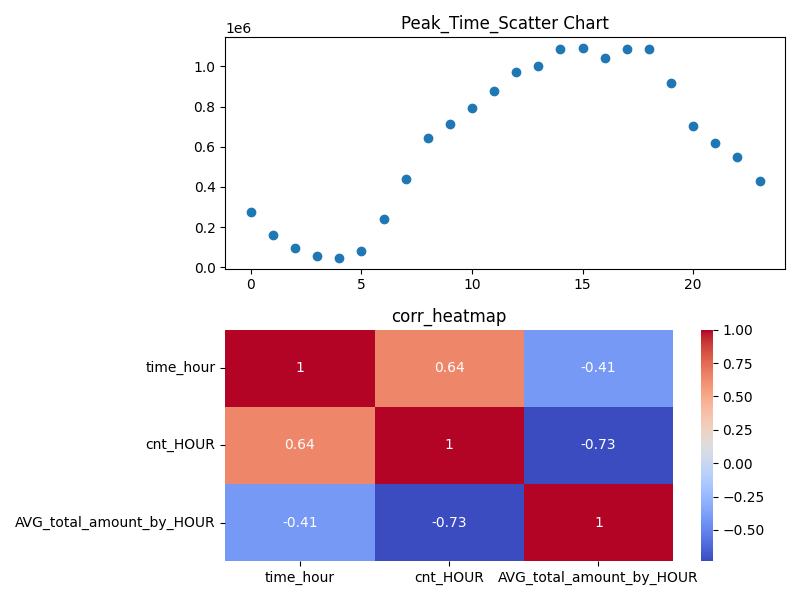

In [146]:
plt.figure(figsize=(8,6))

axes1 = plt.subplot(2,1,1)
axes1.scatter(df2['time_hour'], df2['cnt_HOUR'])
plt.title('Peak_Time_Scatter Chart')

axes2 = plt.subplot(2,1,2)
sns.heatmap(df2.corr(), annot = True, cmap = 'coolwarm')
plt.title('corr_heatmap')

plt.tight_layout()

plt.show()

In [151]:
statistic, pvalue = pearsonr(df2['cnt_HOUR'], df2['AVG_total_amount_by_HOUR'])
print(f'{pvalue:.20f}')

0.00004442707559947090


#### 2-2-5) 결론

<span style="
display : block;
background-color:#fff5b1;
color : red;
font-size : 20px;
font-weight : bold;
text-align : center;">[결론]</span>

- 피크 시간은 13시 ~ 18시에 많다.
- 시간 당 이용횟수가 증가할 수록, 시간 당 지불하는 총 금액의 평균은 낮아진다.
- 피크 시간에는 짧은 운임요금이 많으며 이는 짧은 거리일 수도 있다는 생각이 들게 된다.
- p-value 역시 시간 당 이용횟수와 시간 당 지불하는 총 금액의 평균이 매우 작은 값을 나타내고 있어, 두 변수간 상관관계가 없다는 귀무가설은 기각된다.
- 상관계수 역시, -0.73으로 음의 방향으로 강함을 확인할 수 있다.
- 즉, 시간 당 이용횟수는 시간 당 지불하는 총 금액의 평균과 음의 상관관계를 띄고 있다.

### 3. 지불 유형별 요금, 팁 분석

In [12]:
ss.sql('''
    SELECT
        payment_type
        , AVG(tip_amount)
        , AVG(total_amount)
    FROM table1 as A

    GROUP BY payment_type
    ORDER BY payment_type
    
''').show()

+------------+--------------------+-------------------+
|payment_type|     avg(tip_amount)|  avg(total_amount)|
+------------+--------------------+-------------------+
|        null|  1.6014479849597305|  31.85317404211856|
|           1|  2.8802551464734534|  18.89057563281757|
|           2|3.441382791272625...|  15.42127102120272|
|           3|-0.01341663187366456| 18.068943070461756|
|           4|0.005909593724859213|-2.7711340171627312|
|           5|                 0.0|               17.8|
+------------+--------------------+-------------------+



### 4. 승차 지역 / 하차 지역별 평균거리, 요금

In [13]:
ss.sql('''
    SELECT
        A.PULocationID
        , MAX(B.Zone) as PU_Zone
        , A.DOLocationID
        , MAX(C.Zone) as DO_Zone
        , ROUND(AVG(A.trip_distance), 2) as AVG_trip_distance
        , ROUND(AVG(A.total_amount), 2) as AVG_total_amount
        , COUNT(*) as cnt -- 건수 체크
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    INNER JOIN table2 as C
    on A.DOLocationID = C.LocationID

    GROUP BY A.PULocationID, A.DOLocationID
''').show()

+------------+--------------------+------------+--------------------+-----------------+----------------+---+
|PULocationID|             PU_Zone|DOLocationID|             DO_Zone|AVG_trip_distance|AVG_total_amount|cnt|
+------------+--------------------+------------+--------------------+-----------------+----------------+---+
|           3|Allerton/Pelham G...|          57|              Corona|              4.8|           39.81|  2|
|           3|Allerton/Pelham G...|          89|Flatbush/Ditmas Park|            23.01|           74.73|  2|
|           4|       Alphabet City|         185|      Pelham Parkway|            10.91|           42.06| 11|
|           7|             Astoria|          55|        Coney Island|            14.82|           59.38| 23|
|           7|             Astoria|         132|         JFK Airport|            14.19|           49.42| 77|
|          10|        Baisley Park|          85|             Erasmus|            11.19|           49.95| 29|
|          10|     

In [14]:
ss.sql('''
    SELECT
        A.PULocationID
        , MAX(B.Zone) as PU_Zone
        , A.DOLocationID
        , MAX(C.Zone) as DO_Zone
        , ROUND(AVG(A.trip_distance), 2) as AVG_trip_distance
        , ROUND(AVG(A.total_amount), 2) as AVG_total_amount
        , COUNT(*) as cnt -- 건수 체크
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    INNER JOIN table2 as C
    on A.DOLocationID = C.LocationID

    GROUP BY A.PULocationID, A.DOLocationID
''').toPandas()

,PULocationID,PU_Zone,DOLocationID,DO_Zone,AVG_trip_distance,AVG_total_amount,cnt
0,3,Allerton/Pelham Gardens,57,Corona,4.80,39.81,2
1,3,Allerton/Pelham Gardens,89,Flatbush/Ditmas Park,23.01,74.73,2
2,4,Alphabet City,185,Pelham Parkway,10.91,42.06,11
3,7,Astoria,55,Coney Island,14.82,59.38,23
4,7,Astoria,132,JFK Airport,14.19,49.42,77
...,...,...,...,...,...,...,...
46178,264,NV,191,Queens Village,11.14,39.56,31
46179,265,NA,94,Fordham South,7.15,34.97,117
46180,265,NA,116,Hamilton Heights,7.07,36.21,476
46181,265,NA,133,Kensington,6.22,35.51,154


### 5. 팁의 비율에 따른 거리, 여행 건수 서비스 관련 분석

In [15]:
ss.sql('''
        SELECT
        
            FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 as tip_ratio
            
        FROM table1
        where FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 < 0

''').show()

+---------+
|tip_ratio|
+---------+
|      -30|
|      -40|
|      -30|
|      -30|
|      -30|
|      -20|
|      -30|
|      -30|
|      -30|
|      -20|
|      -40|
|      -30|
|      -30|
|      -30|
|      -30|
|      -30|
|      -20|
|      -30|
|      -40|
|      -30|
+---------+
only showing top 20 rows



In [27]:
ss.sql('''
        SELECT
        
            FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 as tip_ratio
            , ROUND(AVG(trip_distance), 2) as AVG_trip_distance
            , ROUND(AVG(tip_amount), 2) as AVG_tip_amount
            , ROUND(AVG(total_amount), 2) as AVG_total_amount
            
        FROM table1

        GROUP BY tip_ratio
        
        ORDER BY tip_ratio
''').show()

+---------+-----------------+--------------+----------------+
|tip_ratio|AVG_trip_distance|AVG_tip_amount|AVG_total_amount|
+---------+-----------------+--------------+----------------+
|     null|             0.98|           0.0|             0.0|
|    -5670|              0.0|          17.0|            -0.3|
|     -440|             1.71|         10.01|           -2.29|
|     -240|             0.18|           3.0|            -1.3|
|     -180|             0.32|           4.0|            -2.3|
|     -140|             0.74|           5.0|            -3.8|
|     -120|              0.0|           2.0|            -1.8|
|     -110|             2.72|           7.5|            -7.3|
|     -100|             0.71|           7.5|            -7.8|
|      -90|              0.0|         20.02|          -22.78|
|      -80|              0.0|           9.0|           -11.3|
|      -70|              4.8|          6.75|           -10.3|
|      -60|             1.78|           6.2|          -12.02|
|      -

In [30]:
ss.stop()